# Bay Wheels Trip Data 

Bay Wheels is a shared bike rental service run by Lyft in the Bay Area. Before Lyft's aquisition of Motivate in June 2019, the system was previously named Ford Go.

## Investigation Overview

As part of the investigation we will take a deep dive into the data set to try and get an understanding of who is using the service, how long they are using the servie for, when they are using the service and where they are using the service.

## Dataset Overview

The data contains ride data and related attributes of approximately 85,000 rides from January 2018. These attribute include ride date and time, the start and end location of the ride as well as demographical info of the user such as birth year and gender.

In [10]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

%matplotlib inline
sb.set()

In [18]:
# import data
df = pd.read_csv('201801-fordgobike-tripdata_enhanced.csv')

## When are users using the service?

* During the weekday we clearly have two peak periods 7am-9am and 4pm-6pm. The clear explanation for this is that it coincides with periods when people are most likely to commute to work. 
* At weekends however, we do not have such extreme peak times. In fact ride frequency rises smoothly, peaks at around 1pm and declines smoothly.
* Another intersting point we can see here, is that the overall ride frequency for a given 24 hour period is greater during the week than at the weekend. On the next slide we'll take a dive deeper and try to explain why this is the case.

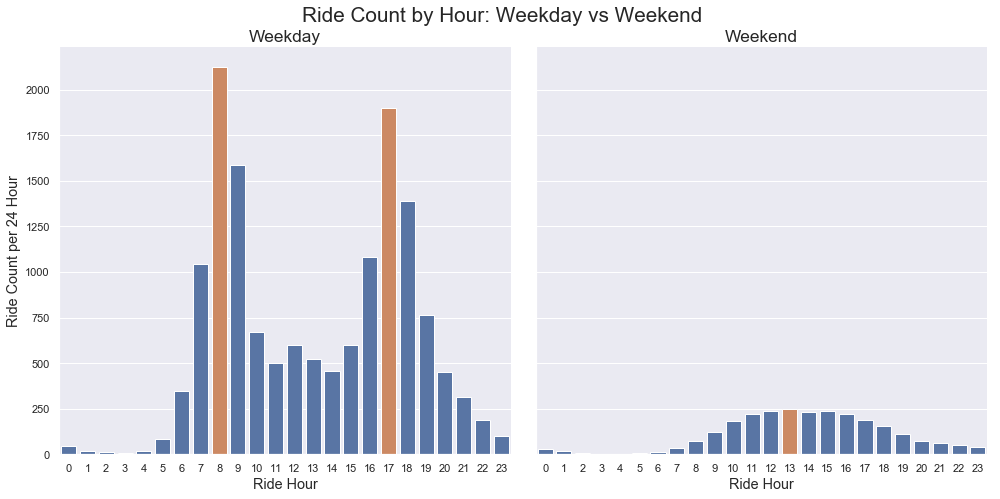

In [20]:
# https://seaborn.pydata.org/generated/seaborn.catplot.html#seaborn.catplot
# https://cduvallet.github.io/posts/2018/11/facetgrid-ylabel-access

# function to define mode
def define_modes(vec):
    day_type = vec[0]
    hour = vec[1]
    
    if day_type == 'Weekday' and hour in [8, 17]:
        return 'mode'
    elif day_type == 'Weekend' and hour in [13]:
        return 'mode'
    else:
        return 'not_mode'

# define new feature weekend vs weekdays
day_cat_order = ['Weekday', 'Weekend']
day_cat_ordinal = pd.api.types.CategoricalDtype(ordered = True, categories = day_cat_order)
df['day_category'] = df['day_category'].astype(day_cat_ordinal)

# define modes - later to highlight modes in plot
df['is_mode'] = df[['day_category','start_hour']].apply(define_modes, axis = 1)

# order applied to flip colours when is_mode plotted as hue
mode_order = ['not_mode', 'mode']
mode_ordinal = pd.api.types.CategoricalDtype(ordered = True, categories = mode_order)
df['is_mode'] = df['is_mode'].astype(mode_ordinal)

# ride count needs to be per 24 hour period for plot. create new dataframe for plot which divides count by #day
# e.g. divide 5 for weekdays
WA_Count = df.groupby(['day_category','is_mode','start_hour']).count()['start_time'].reset_index()
WA_Count['WA_Count'] = WA_Count['start_time']
WA_Count['day_cat_WA'] = WA_Count['day_category'].apply(lambda x: (1/5) if x == 'Weekday' else (1/5))
WA_Count['WA_Count'] = WA_Count['WA_Count'].astype(float) * WA_Count['day_cat_WA'].astype(float)
WA_Count.drop(['start_time','day_cat_WA'], axis = 1, inplace = True)




# plot FacetGrid of barplots
grid = sb.catplot(data = WA_Count, x = "start_hour", y = 'WA_Count', col="day_category", hue = 'is_mode', 
                  dodge = False, legend = False, kind="bar", height = 7);

# set axis labels
grid.set_ylabels('Ride Count per 24 Hour');
grid.set_xlabels('Ride Hour');

# adjust position of facetGrid and insert overall Title
plt.subplots_adjust(top=0.9);
grid.fig.suptitle('Ride Count by Hour: Weekday vs Weekend', fontsize='xx-large');

# change fontsize of axis as well as plot titles
for ax in grid.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize='large');
    ax.set_ylabel(ax.get_ylabel(), fontsize='large');
    ax.set_title(ax.get_title().split()[-1], fontsize='x-large');

## Explaining Weekday vs Weekend User Behaviour

* There are two types of user that use Bay Wheels, Customers who ride on a one off basis and Subscribers who are regular users of the service.
* We can see here that the user base is heavily weighted towards Subscribers vs Customers
* Customers are nearly 3 times more likely to use during the service during the week. 
* In combination with the previous slide, it is a possiblity the susbcribers main use case is for commuting over casual use although this would need further reasearch to verify.
* Although by comparison Customers (one off users) use the service far less regularly, it is more common to use the service at weekends. 

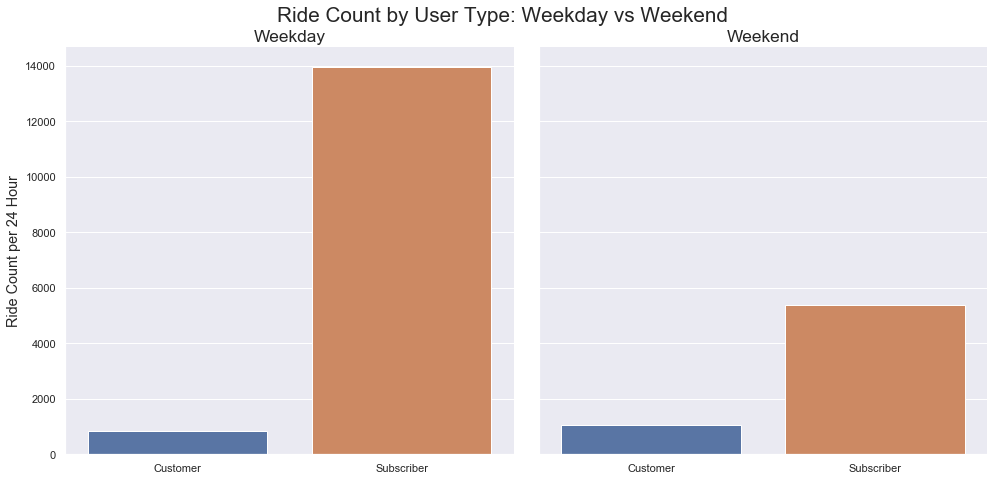

In [21]:
# ride count needs to be per 24 hour period for plot. create new dataframe for plot which divides count by #day
# e.g. divide 5 for weekdays
WA_Count = df.groupby(['day_category','user_type']).count()['start_time'].reset_index()
WA_Count['WA_Count'] = WA_Count['start_time']
WA_Count['day_cat_WA'] = WA_Count['day_category'].apply(lambda x: (1/5) if x == 'Weekday' else (1/2))
WA_Count['WA_Count'] = WA_Count['WA_Count'].astype(float) * WA_Count['day_cat_WA'].astype(float)
WA_Count.drop(['start_time','day_cat_WA'], axis = 1, inplace = True)
    
    

grid = sb.catplot(data = WA_Count, x = "user_type", y = 'WA_Count', col="day_category", 
                  dodge = False, legend = False, kind="bar", height = 7);

# set axis labels
grid.set_ylabels('Ride Count per 24 Hour')
grid.set_xlabels('User Type')

# adjust position of facetGrid and insert overall Title
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Ride Count by User Type: Weekday vs Weekend', fontsize='xx-large')
grid.set_xlabels('')

# change fontsize of axis as well as plot titles
for ax in grid.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize='large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='large')
    ax.set_title(ax.get_title().split()[-1], fontsize='x-large')
    

## Ride Duration

Ride durations in the dataset take on a very large range of values, from 61 seconds to 84,609 seconds (nearly 24 hours!) Plotted on a logarithmic scale, the distribution of ride durations takes on a normal shape. The mean duration is 728 seconds or roughly 12 minutes. 

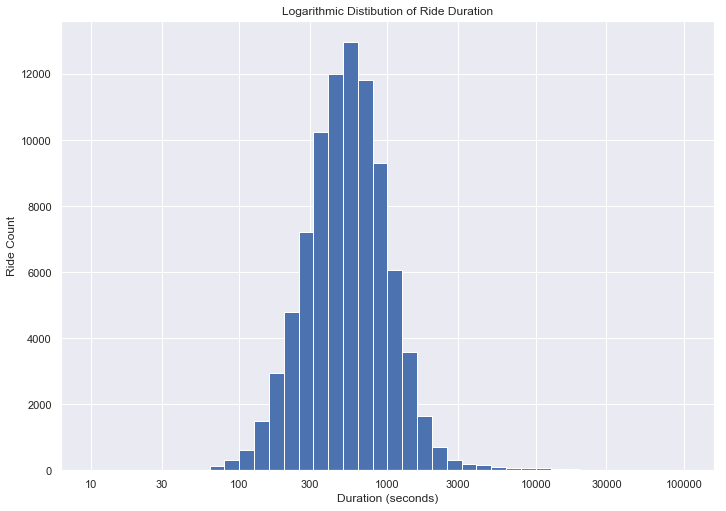

In [14]:
# How long do users use the bikes for?
bins = 10 ** np.arange(1, 5 + 0.1, 0.1)
ticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000, 100000]
labels = ['{}'.format(v) for v in ticks]
plt.figure(figsize=[ 11.69, 8.27]);
plt.hist(data = df, x = 'duration_sec', bins = bins);
plt.xscale('log');
plt.xticks(ticks, labels);
plt.xlabel('Duration (seconds)');
plt.ylabel('Ride Count');
plt.title('Logarithmic Distibution of Ride Duration');

## Ride Duration by Age Group

The heatmap below gives us an interesting insight into not only the common ages of users but the duration of those users are riding for. The concentration users are commonly born between 1980 - 1990 and are using the service for a duration of 300-1000 seconds.

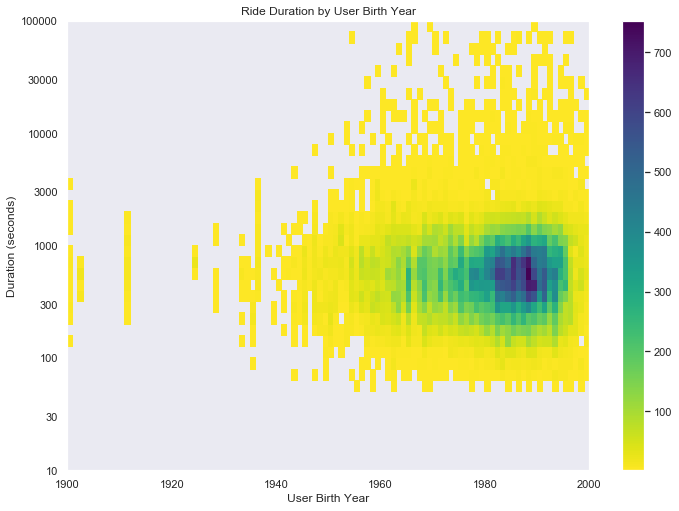

In [15]:
# How does duration vary based upon birth year?

plt.figure(figsize=[ 11.69, 8.27]);

y_bins = 10 ** np.arange(1, 5 + 0.1, 0.1)
x_bins = np.arange(1900, 2000 + 1, 1)

plt.hist2d(data = df, x = 'member_birth_year', y = 'duration_sec'
           , cmin = 0.1, cmap = 'viridis_r',
          bins = [x_bins, y_bins]);
plt.colorbar()
plt.yscale('log')
plt.yticks(ticks, labels);

plt.xlabel('User Birth Year');
plt.ylabel('Duration (seconds)');
plt.title('Ride Duration by User Birth Year');

## Recap
* Let's take a step back for a moment and review what we've covers. We've looked at user behaviour at weekends vs weekdays, how Customers and Subscribers use the service, the duration of rides and how the age of our user affects that duration.
* Next we will take a look at the different regions in the Bay Area which the service is used.

## Where is the service used? 

By the plot below, we can see that stations are deployed to three geographical regions. These are, San Fransico, East Bay and South Bay.

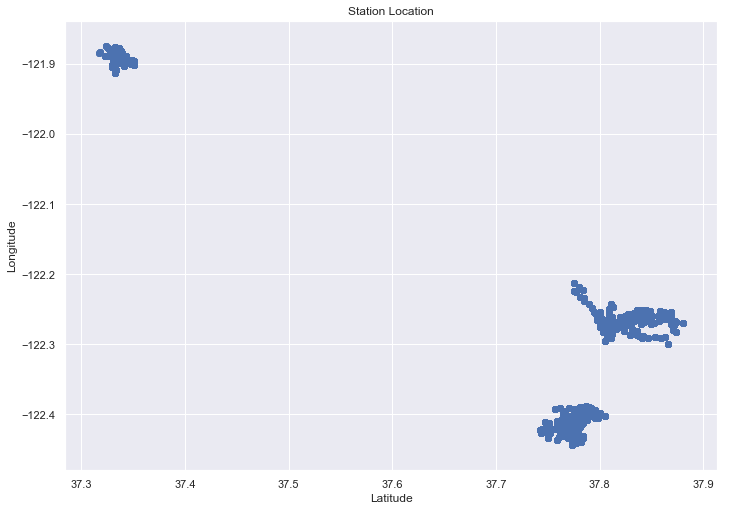

In [16]:
# Where are the users using the bikes? Check to see the different regions in which the service operates.
plt.figure(figsize=[ 11.69, 8.27]);
plt.scatter(data = df, x = 'start_station_latitude', y = 'start_station_longitude', marker = 'o');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
plt.title('Station Location');

# How is supply and demand matched accross regions? 

Looking at the two demand metrics, % of total rides and % of total ride duration, split by region we can see that the highest demand is in the San-Fransico area, followed by East-Bay and the South-Bay. 

However, by comparing to our supply metrics, % of total stations and % of total bikes deployed, we can see that San-Fransico's high demand is underserved. 

Bay Wheels may want to increase the number of bikes in San-Fransico by increasing the number or the capacity of their stations. In doing so either more bikes could be added to the overall system or bikes could be redeployed from the other two regions to better serve demand. 

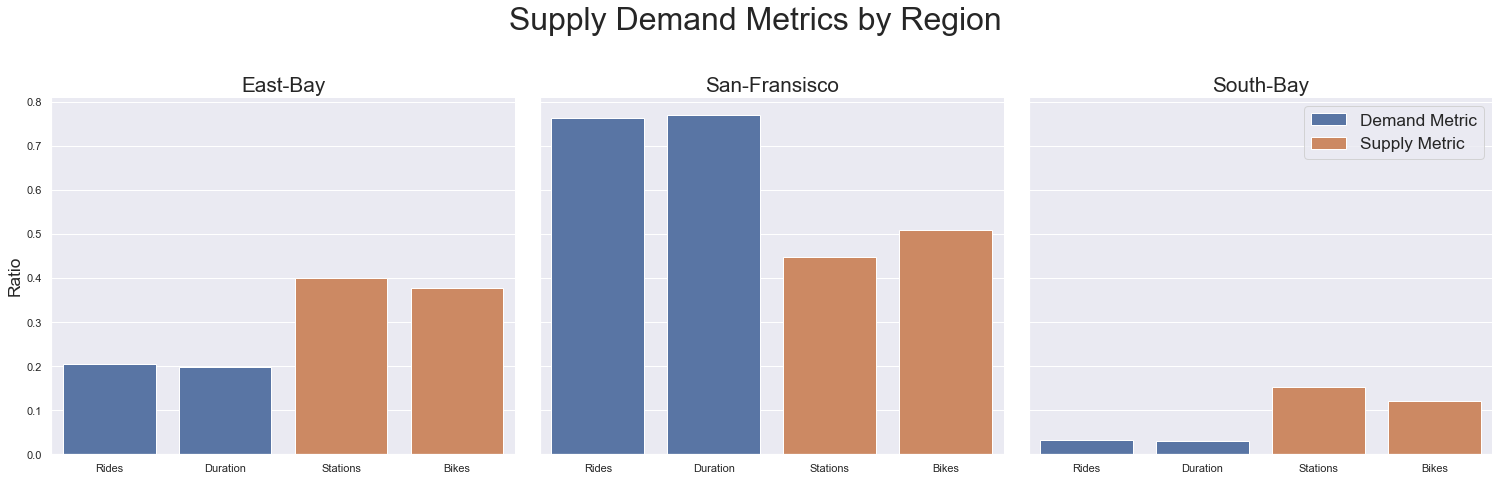

In [17]:
df = pd.read_csv('supply_demand.csv')
grid = sb.catplot(data = df, x = "metric", y = 'ratio', col="start_region", hue = 'metric_type', 
                  dodge = False, legend = False, kind="bar", height = 7);

# set axis labels
grid.set_ylabels('Ratio')
grid.set_xlabels('')
plt.legend(fontsize='x-large')

# adjust position of facetGrid and insert overall Title
plt.subplots_adjust(top=0.8)
grid.fig.suptitle('Supply Demand Metrics by Region', fontsize='32')
    
# change fontsize of axis as well as plot titles
for ax in grid.axes.flat:
    ax.set_xlabel(ax.get_xlabel(), fontsize='x-large')
    ax.set_ylabel(ax.get_ylabel(), fontsize='x-large')
    ax.set_title(ax.get_title().split()[-1], fontsize='xx-large')